# Principal component analysis
1. load data and meta data
2. basic minimal preprocessing
3. perform PCA
4. plot PCA embeddings, variance and loadings

In [ ]:
import logging
import numpy as np
from pathlib import PureWindowsPath
import pandas as pd

import tempfile
import alphapepttools as at
from alphapepttools.pl.figure import create_figure, label_axes
from alphapepttools.pl.plots import Plots
from alphapepttools.pl.colors import BaseColormaps


logging.basicConfig(level=logging.INFO)

## Load the data 

We download the data from [this](https://datashare.biochem.mpg.de/s/WPLspCwygBEMTa5) folder (ca. 2 megabytes)

In [ ]:
output_dir = "./datasets/data_for_04_basic_PCA_workflow"
pg_table_path = at.data.get_data("hela_pg_diann", output_dir=output_dir if output_dir else tempfile.mkdtemp())
metadata_path = at.data.get_data("hela_metadata", output_dir=output_dir if output_dir else tempfile.mkdtemp())

./datasets/data_for_04_basic_PCA_workflow/report.pg_matrix.tsv already exists (1.0532913208007812 MB)
./datasets/data_for_04_basic_PCA_workflow/simple_metadata.csv already exists (0.0013446807861328125 MB)


We can read the data easily with the `alphapepttools.io` functionalities and match the metadata to the observations

In [ ]:
# Read PG table and
# Parse full filepaths to file names (as in metadata file)
# Set uniprot ids as index
adata = at.io.read_pg_table(pg_table_path, search_engine="diann")
adata.obs_names = adata.obs_names.to_series().apply(lambda x: PureWindowsPath(str(x)).stem)
adata.var = adata.var.reset_index(names="protein_names").set_index("uniprot_ids")

# Read metadata
metadata = pd.read_csv(metadata_path, sep=",", index_col="filename")

adata = at.pp.add_metadata(adata=adata, incoming_metadata=metadata, axis=0)
adata

AnnData object with n_obs × n_vars = 18 × 4954
    obs: 'replicate', 'fraction'
    var: 'protein_names', 'genes', 'description'

## Basic EDA on a synthetic example dataset:

1. Generate example data
2. Filter for data completeness on sample level
3. Visualize samples as histograms
4. Save data

### Filter by data completeness:

Remove features which have more than the allowed fraction of missing values

In [ ]:
print("The numeric data in the anndata object:")
display(adata.to_df().head())

print("The sample-level metadata in the anndata object:")
display(adata.obs.head())

print("The feature-level metadata in the anndata object:")
display(adata.var.head())

#  filter out features with more than 25 % missing values
print("Before filtering, the shape of the anndata object: ", adata.shape)
adata = at.pp.filter_data_completeness(adata=adata, max_missing=0.25, action="drop")
print("After filtering, the shape of the anndata object: ", adata.shape)

print("The numeric data in the anndata object:")
display(adata.to_df().head())

print("The sample-level metadata in the anndata object:")
display(adata.obs.head())

print("The feature-level metadata in the anndata object:")
display(adata.var.head())

The numeric data in the anndata object:


uniprot_ids                                         A0A024R1R8;Q9Y2S6  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...          9506220.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         25866000.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         10150200.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         14660600.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         23477900.0   

uniprot_ids                                         A0A0B4J2F0  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   9930580.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  11627800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   8741560.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   1497570.0   

uniprot_ids                                         A0A0J9YX75;A0A0J9YXY3;P0DPF7  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...                           NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...                           NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...                           NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...                           NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...                           NaN   

uniprot_ids                                             A0AV96      A0FGR8  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   6414570.0  29546900.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  18604800.0  18958500.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   6550420.0  28679800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   9638120.0  35471700.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  16496400.0  27413400.0   

uniprot_ids                                            A0JLT2      A0PJW6  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...        NaN  19563300.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  3202770.0         NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...        NaN  19387300.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...        NaN  15716300.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...        NaN   2334540.0   

uniprot_ids                                             A1L0T0     A1L390  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  23059400.0  1346120.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  14090600.0   790375.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  24248100.0   963907.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  36269500.0        NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  24950500.0        NaN   

uniprot_ids                                             A1X283  ...  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  11691800.0  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  23128600.0  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   9263040.0  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  11779400.0  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  21687600.0  ...   

uniprot_ids                                             Q9Y6N5    Q9Y6N6  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  39051400.0  172419.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  10291200.0       NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  38928800.0       NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  33905400.0  237138.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   8834620.0  187094.0   

uniprot_ids                                            Q9Y6N7     Q9Y6N8  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  6796840.0  8998980.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  3829290.0        NaN   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  5441930.0  9034600.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  5068170.0  7413300.0   


The sample-level metadata in the anndata object:


replicate fraction
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map2       3K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1       1K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1       3K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1       6K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1      12K

The feature-level metadata in the anndata object:


protein_names  \
uniprot_ids                                                         
A0A024R1R8;Q9Y2S6                          TMA7B_HUMAN;TMA7_HUMAN   
A0A0B4J2F0                                            PIOS1_HUMAN   
A0A0J9YX75;A0A0J9YXY3;P0DPF7  TVB62_HUMAN;TVB63_HUMAN;TVB69_HUMAN   
A0AV96                                                RBM47_HUMAN   
A0FGR8                                                ESYT2_HUMAN   

                                                genes  \
uniprot_ids                                             
A0A024R1R8;Q9Y2S6                          TMA7;TMA7B   
A0A0B4J2F0                                    PIGBOS1   
A0A0J9YX75;A0A0J9YXY3;P0DPF7  TRBV6-2;TRBV6-3;TRBV6-9   
A0AV96                                          RBM47   
A0FGR8                                          ESYT2   

                                                              description  
uniprot_ids                                                                
A0A024R1R8;Q9Y2S6             Translation machinery-associated protein 7B  
A0A0B4J2F0                                                Protein PIGBOS1  
A0A0J9YX75;A0A0J9YXY3;P0DPF7            T cell receptor beta variable 6-9  
A0AV96                                             RNA-binding protein 47  
A0FGR8                                           Extended synaptotagmin-2

INFO:root:pp.filter_data_completeness(): drop 2123 / 4954 features with >0.25 missing in any group.


Before filtering, the shape of the anndata object:  (18, 4954)
After filtering, the shape of the anndata object:  (18, 2831)
The numeric data in the anndata object:


uniprot_ids                                         A0A024R1R8;Q9Y2S6  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...          9506220.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         25866000.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         10150200.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         14660600.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         23477900.0   

uniprot_ids                                             A0AV96      A0FGR8  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   6414570.0  29546900.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  18604800.0  18958500.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   6550420.0  28679800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   9638120.0  35471700.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  16496400.0  27413400.0   

uniprot_ids                                             A1L0T0      A1X283  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  23059400.0  11691800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  14090600.0  23128600.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  24248100.0   9263040.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  36269500.0  11779400.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  24950500.0  21687600.0   

uniprot_ids                                            A5PLL7      A5YKK6  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  2741150.0  10835800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  4624200.0  11243600.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  3809220.0  10480100.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  5127720.0  19063600.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  5740560.0  39849800.0   

uniprot_ids                                         A6NCE7;Q9GZQ8    A6NDG6  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      5629360.0  561137.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      7728880.0  462468.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      7059070.0  700098.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      8905940.0  582714.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      8597510.0  595144.0   

uniprot_ids                                             A6NHR9  ...  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   3789200.0  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  47274600.0  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         NaN  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         NaN  ...   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   3586450.0  ...   

uniprot_ids                                             Q9Y6K5      Q9Y6M0  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   8955980.0  27799800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   9021290.0  18298000.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   7307580.0  23668700.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  12709900.0  39207800.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  18124000.0  30144100.0   

uniprot_ids                                             Q9Y6M1     Q9Y6M4  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   3070990.0  3151630.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...         NaN  1579620.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   3084110.0  3130200.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...   6057120.0  3672700.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  10509100.0  3353660.0   

uniprot_ids                                             Q9Y6M5     Q9Y6N7  \
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  64329500.0  6796840.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  38458300.0  3829290.0   
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...  60378200.0  5441930.0   
20210131_EXPL4_ViA

The sample-level metadata in the anndata object:


replicate fraction
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map2       3K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1       1K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1       3K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1       6K
20210131_EXPL4_ViAl_SA_HeLa_Evosep_21min_DIA_12...      Map1      12K

The feature-level metadata in the anndata object:


protein_names       genes  \
uniprot_ids                                             
A0A024R1R8;Q9Y2S6  TMA7B_HUMAN;TMA7_HUMAN  TMA7;TMA7B   
A0AV96                        RBM47_HUMAN       RBM47   
A0FGR8                        ESYT2_HUMAN       ESYT2   
A1L0T0                        HACL2_HUMAN       ILVBL   
A1X283                        SPD2B_HUMAN    SH3PXD2B   

                                                   description  
uniprot_ids                                                     
A0A024R1R8;Q9Y2S6  Translation machinery-associated protein 7B  
A0AV96                                  RNA-binding protein 47  
A0FGR8                                Extended synaptotagmin-2  
A1L0T0                               2-hydroxyacyl-CoA lyase 2  
A1X283                 SH3 and PX domain-containing protein 2B

## Creating new layers prior to preprocessing

This way, we can save the raw data and try different pp steps on the raw data.

In [ ]:
# save the raw data before log transformation
adata.layers["raw"] = adata.X.copy()

# log2 transform the data
adata.X = np.log2(adata.X + 1)

### Visualize the distribution of values in different levels of an observational metadata variable

In this example, check the distribution of "gene_1" expression values per cell type.

INFO:root:Column 'A1L0T0' found in: data.var_names. Using that
INFO:root:Column 'A1L0T0' found in: data.var_names. Using that
INFO:root:Column 'replicate' found in: data.obs.columns. Using that
  if na_values:



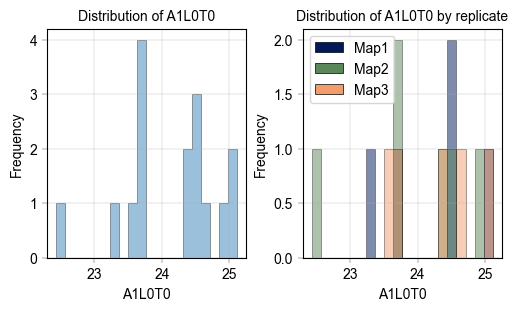

In [ ]:
# Apply the AxisManager to make axes iterable and apply consistent alphapepttools styling.
# Axes can also be accessed directly by indexing the axm object.
fig, axm = create_figure(nrows=1, ncols=2, figsize=(5, 3))

# Plot.histogram handles adata natively. Columns from the data and metadata are accessible
# Focus on the distribution of protein A1L0T0
ax = axm.next()
Plots.histogram(
    data=adata,
    value_column="A1L0T0",
    bins=20,
    legend="auto",
    ax=ax,
    hist_kwargs={"alpha": 0.5, "histtype": "stepfilled", "linewidth": 0.5, "edgecolor": "black"},
)
label_axes(ax, "A1L0T0", "Frequency", "Distribution of A1L0T0")

# Focus on the distribution of protein A1L0T0 in the different replicates
ax = axm.next()
Plots.histogram(
    data=adata,
    value_column="A1L0T0",
    color_map_column="replicate",
    bins=20,
    legend="auto",
    ax=ax,
    hist_kwargs={"alpha": 0.5, "histtype": "stepfilled", "linewidth": 0.5, "edgecolor": "black"},
)
label_axes(ax, "A1L0T0", "Frequency", "Distribution of A1L0T0 by replicate")

# # save figure
# save_figure(
#     fig=fig,
#     filename="sample_histogram.png",
#     output_dir=output_directory,
#     dpi=300,
#     transparent=False,
# )

### Running PCA

Before running PCA, we need to filter out NaN values. PCA can not be computed on matrices with missing values. Therefore, prior to PCA, we will create a list of 'core proteins' of proteins detected in all observations, save it in the feature meta data frame (adata.var)

In [ ]:
# add a new column to the adata.var object with the name "is_core" to indicate whether the feature is part of the core proteome
adata = at.pp.filter_data_completeness(adata, max_missing=0, action="flag", var_colname="is_core")

# view hoe many features are part of the core proteome
print("The number of features in the core proteome:")
print(adata.var["is_core"].value_counts())

INFO:root:pp.filter_data_completeness(): flag 1025 / 2831 features with >0.00 missing in any group.


The number of features in the core proteome:
is_core
True     1806
False    1025
Name: count, dtype: int64


Now we can run PCA, specifying the adata.var column that filters the proteins by 100% completeness:

In [ ]:
# this function is now implemented on sample level (PCA of the observations).
at.tl.pca(adata, meta_data_mask_column_name="is_core", n_comps=10)

# view the PCA results
print("The dimensions of PC coordinates in the adata.obsm are (n_obs x n_comp):")
print(adata.obsm["X_pca_obs"].shape)
print("The PCA loadings in the adata.varm are (n_var x n_comp):")
print(adata.varm["PCs_obs"].shape)
print("Ratio of explained variance (n_comp):")
print(adata.uns["variance_pca_obs"]["variance_ratio"])
print("The explained variance (n_comp):")
print(adata.uns["variance_pca_obs"]["variance"])

INFO:alphapepttools.tl.embeddings:computing PCA


The dimensions of PC coordinates in the adata.obsm are (n_obs x n_comp):
(18, 10)
The PCA loadings in the adata.varm are (n_var x n_comp):
(2831, 10)
Ratio of explained variance (n_comp):
[0.56593504 0.33056594 0.06844902 0.01339105 0.00388991 0.00288049
 0.0023081  0.00220095 0.00194543 0.0017315 ]
The explained variance (n_comp):
[1009.50632405  589.65850994  122.09831939   23.88675892    6.93875425
    5.13817412    4.11715411    3.92601867    3.47022027    3.08861607]


In addition to running PCA to get a dimentional reduction of the observations (samples), we can also perform PCA on the features (proteins). 

In [ ]:
# Now run PCA on the protein space to get their projection in the PCA space.
at.tl.pca(adata, meta_data_mask_column_name="is_core", n_comps=10, dim_space="var")

# view the PCA results for features
print("----- PCA ON FEATURES -----")
print("The dimensions of PC coordinates in the adata.varm are (n_obs x n_comp):")
print(adata.varm["X_pca_var"].shape)
print("The PCA loadings of the samples in the adata.obsm are (n_var x n_comp):")
print(adata.obsm["PCs_var"].shape)
print("Ratio of explained variance (n_comp):")
print(adata.uns["variance_pca_var"]["variance_ratio"])
print("The explained variance (n_comp):")
print(adata.uns["variance_pca_var"]["variance"])

INFO:alphapepttools.tl.embeddings:computing PCA


----- PCA ON FEATURES -----
The dimensions of PC coordinates in the adata.varm are (n_obs x n_comp):
(2831, 10)
The PCA loadings of the samples in the adata.obsm are (n_var x n_comp):
(18, 10)
Ratio of explained variance (n_comp):
[8.07567317e-01 1.13818512e-01 6.33157115e-02 8.74927065e-03
 2.21018860e-03 7.89962453e-04 5.76627224e-04 4.64255895e-04
 4.48561680e-04 3.63473757e-04]
The explained variance (n_comp):
[6.64865141e+01 9.37060716e+00 5.21274308e+00 7.20322002e-01
 1.81963451e-01 6.50371166e-02 4.74733601e-02 3.82218986e-02
 3.69298036e-02 2.99245680e-02]


### Plot PCA results 
We can plot the PCA results on a 2D projection, look at the explained var in each PC using the scree plot, and plot the loadings od the PCs, either per PC or a scatter of 2 PCs, to understand their 'drivers'. 

INFO:root:Column 'replicate' found in: data.obs.columns. Using that
INFO:root:Column 'replicate' found in: data.obs.columns. Using that
  if na_values:

INFO:root:Column 'pc_1' found in: data.var_names. Using that
INFO:root:Column 'pc_2' found in: data.var_names. Using that


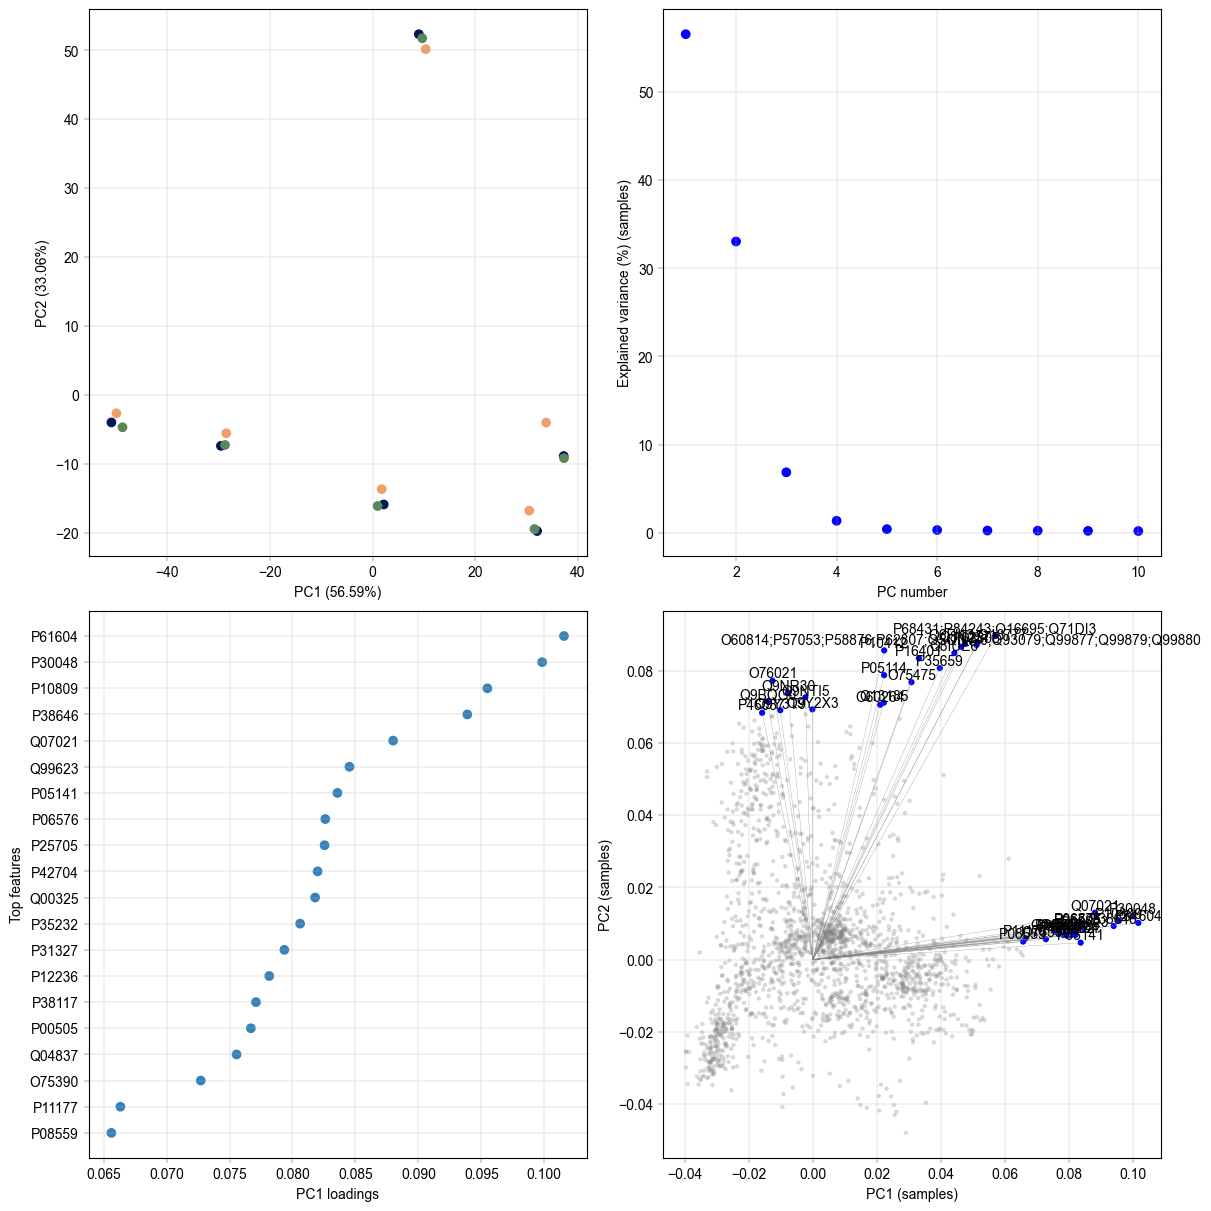

In [ ]:
fig, axm = create_figure(2, 2, figsize=(12, 12))

ax = axm.next()
# PCA plot colored by replicate
Plots.plot_pca(
    data=adata,
    ax=ax,
    x_column=1,
    y_column=2,
    label=False,
    label_column=None,
    embeddings_name=None,
    color_map_column="replicate",
)

# scree plot to show the explained variance by each PC
ax = axm.next()
Plots.scree_plot(adata=adata, ax=ax, n_pcs=50)

# top loadings of the first PC
ax = axm.next()
Plots.plot_pca_loadings(
    data=adata,
    ax=ax,
    dim=1,
    nfeatures=20,
)

# 2d loading plot with highlighted top 20 loadings
ax = axm.next()
Plots.plot_pca_loadings_2d(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    nfeatures=20,
    add_labels=True,
    add_lines=True,
    scatter_kwargs=None,
)

We can also color the samples on the PCA based on their level of expression of specific proteins. 

INFO:root:Column 'Q07021' found in: data.obs.columns. Using that
INFO:root:Column 'pc_1' found in: data.var_names. Using that
INFO:root:Column 'pc_2' found in: data.var_names. Using that


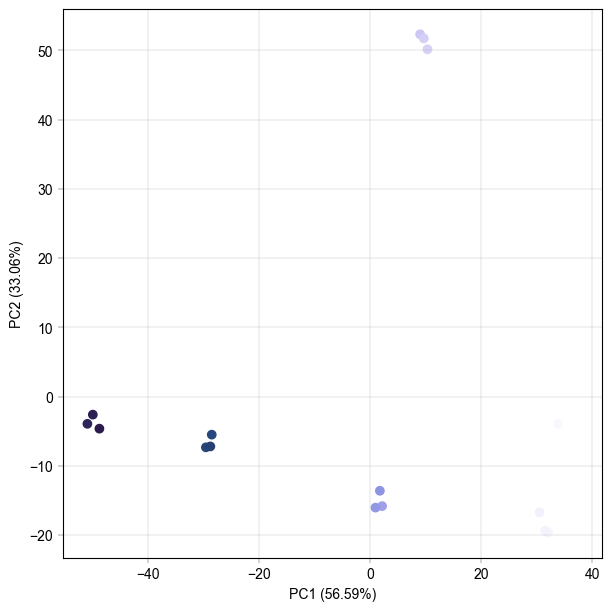

In [ ]:
fig, axm = create_figure(1, 1, figsize=(6, 6))

ax = axm.next()
prot = "Q07021"
Plots.plot_pca(
    data=adata,
    ax=ax,
    x_column=1,
    y_column=2,
    label=False,
    label_column=None,
    embeddings_name=None,
    color_map_column=prot,
    palette=BaseColormaps.get("sequential"),
)

### Plot PCA results for feature PCA 
Just like the PCA on the samples, we can plot the same plots for the results of PCA calculated on the features.  

INFO:root:Column 'pc_1' found in: data.var_names. Using that
INFO:root:Column 'pc_2' found in: data.var_names. Using that


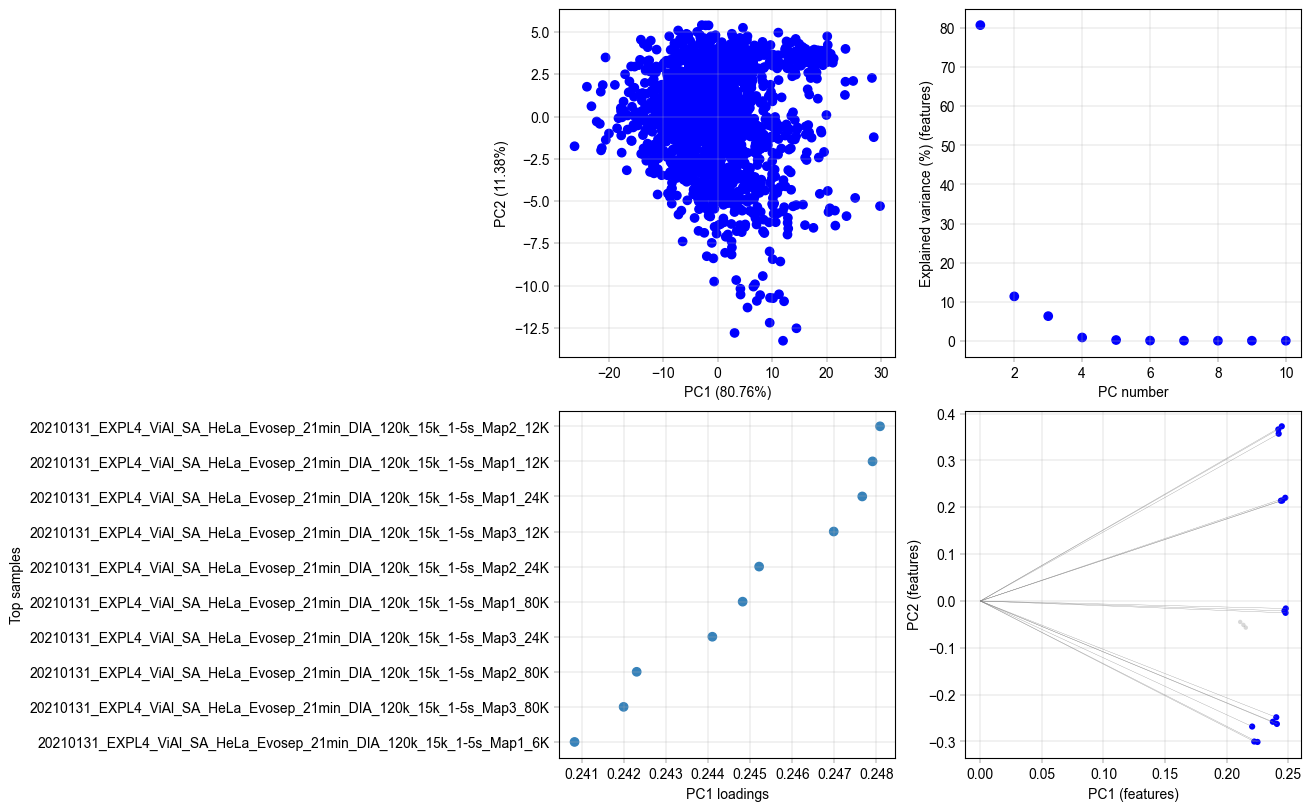

In [ ]:
# now produce the PCAs plot for the features
fig, axm = create_figure(2, 2, figsize=(13, 8))

ax = axm.next()
Plots.plot_pca(
    data=adata,
    ax=ax,
    x_column=1,
    y_column=2,
    dim_space="var",
    label=False,
    label_column=None,
    embeddings_name=None,
)

ax = axm.next()
Plots.scree_plot(adata=adata, ax=ax, n_pcs=50, dim_space="var")

ax = axm.next()
Plots.plot_pca_loadings(data=adata, ax=ax, dim=1, nfeatures=10, dim_space="var")

ax = axm.next()
Plots.plot_pca_loadings_2d(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=2,
    nfeatures=10,
    add_labels=False,
    add_lines=True,
    scatter_kwargs=None,
    dim_space="var",
)

### UMAP Visualization with Scanpy

To explore and visualize the high-dimensional proteomics data, we use **UMAP (Uniform Manifold Approximation and Projection)** as implemented in **Scanpy**. UMAP projects complex, high-dimensional feature spaces into a lower-dimensional space (typically 2D) while preserving the local and global structure of the data. This allows us to identify clusters, relationships, and potential outliers in the proteomic profiles at a glance.

In this notebook, Scanpy’s `sc.pp.neighbors()` and `sc.tl.umap()` functions are applied to the processed data matrix to compute a nearest-neighbor graph and then generate UMAP coordinates. We will use the sample PCA matrix for neighbor calculations. The resulting UMAP embedding provides an intuitive visualization of sample similarity and grouping based on proteomic features, complementing downstream analyses such as clustering or differential expression.


In [ ]:
import scanpy as sc

sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_pca_obs")  # use the PCA results on samples
sc.tl.umap(adata)

In [ ]:
# location of the umap coordinates in the adata.obsm
print("The UMAP coordinates in the adata.obsm are in adata.obsm['X_umap'] with shape: ", adata.obsm["X_umap"].shape)
print(adata.obsm["X_umap"])

The UMAP coordinates in the adata.obsm are in adata.obsm['X_umap'] with shape:  (18, 2)
[[ 7.4034281e+00  1.5592499e-01]
 [ 7.2009835e+00 -2.5695477e+00]
 [ 7.5915337e+00 -7.8027385e-01]
 [ 9.6020727e+00 -8.0324888e-01]
 [ 9.7245064e+00 -2.3821766e+00]
 [ 1.0197392e+01 -4.0992904e+00]
 [ 9.4643431e+00 -4.8978992e+00]
 [ 6.3894439e+00 -2.6039217e+00]
 [ 8.7024069e+00 -1.0093675e+00]
 [ 8.6669664e+00 -2.7722642e+00]
 [ 9.6294870e+00 -3.8831391e+00]
 [ 8.7243156e+00 -5.2219939e+00]
 [ 6.7794323e+00 -1.8091360e+00]
 [ 8.2347479e+00 -7.1188253e-03]
 [ 9.0395899e+00 -1.8811136e-01]
 [ 8.9587097e+00 -2.0429587e+00]
 [ 8.5955973e+00 -3.9610267e+00]
 [ 9.9694805e+00 -5.5260568e+00]]


### Plot UMAP
We can either plot the UMAP results using scanpy's plotting function, or we can use alphapepttools plotting function, with adding the umap coordinates directly to the obs df.


... storing 'replicate' as categorical
... storing 'fraction' as categorical
... storing 'genes' as categorical
... storing 'description' as categorical


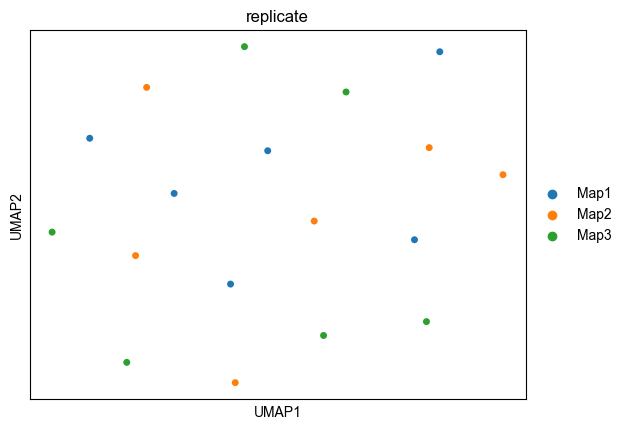

In [ ]:
# scanpy's plotting function
sc.pl.umap(adata, color="replicate", size=100)  # the size is usually much smaller

Another option is to copy the coordinates into the `adata.obs` data frame, to plot in using `scatter` function in `alphapepttools` package

INFO:root:Column 'replicate' found in: data.obs.columns. Using that


INFO:root:Column 'replicate' found in: data.obs.columns. Using that
INFO:root:Column 'replicate' found in: data.obs.columns. Using that
  if na_values:

INFO:root:Column 'UMAP1' found in: data.obs.columns. Using that
INFO:root:Column 'UMAP2' found in: data.obs.columns. Using that


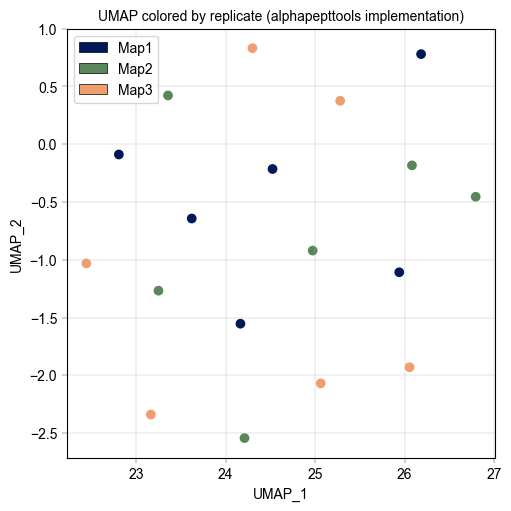

In [ ]:
adata.obs["UMAP1"] = adata.obsm["X_umap"][:, 0]
adata.obs["UMAP2"] = adata.obsm["X_umap"][:, 1]

fig, axm = create_figure(1, 1, figsize=(5, 5))
ax = axm.next()
Plots.scatter(adata, x_column="UMAP1", y_column="UMAP2", color_map_column="replicate", ax=ax, legend="auto")

label_axes(
    ax=ax,
    xlabel="UMAP_1",
    ylabel="UMAP_2",
    title="UMAP colored by replicate (alphapepttools implementation)",
)